[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Chuvard/XGBoost/blob/main/XGBoost.ipynb)

Outline
1. Problem statement
2. Importing packages
3. Data importing
4. Train / Test Split
5. Create Time Series Features
6. Create XGBoost Model
    * 6.1. Feature Importances
    * 6.2. Forecast on Test Set
    * 6.3. Look at predictions versus actuals
    * 6.4. Error Metrics On Test Set
    * 6.5. Look at the Worst and the Best Predicted Days
    * 6.6. Plotting some best / worst predicted days

### 1. Problem Statement: 
- Predict [hourly energy consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv) through time series forecasting using the XGBoost (boosted trees) machine learning algorithm. Finding trends in energy consumption around hours of the day, or much longer trends.

### 2. Importing packages

In [1]:
### Import packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

### 3. Data importing

In [5]:
### Import a data set (Hourly energy consumption data from 2002-2018 for the entire east region)
pjme = pd.read_csv('https://raw.githubusercontent.com/Chuvard/XGBoost/main/data/PJME_hourly.csv', index_col=[0], parse_dates=[0])
print(pjme.head())
print('\n')
print(pjme.columns)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0


Index(['PJME_MW'], dtype='object')


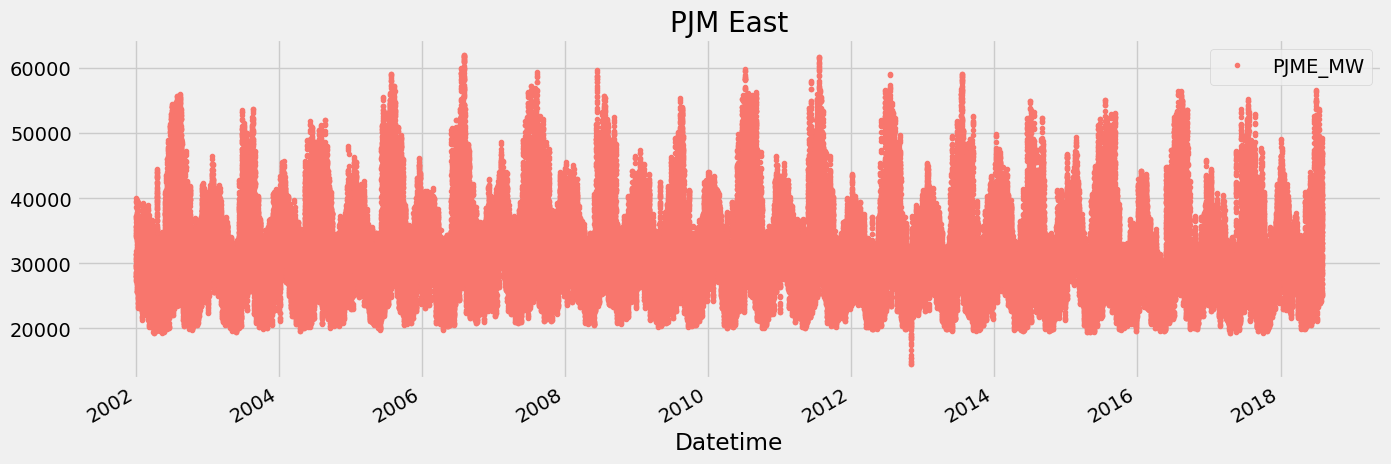

In [3]:
### Plot the data from a data set
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### 4. Train / Test Split
Cut off the data after 2015 to use as our validation (testing data) set.

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()
print(f"The shape of training dataset: {len(pjme_train)}")
print(f"The shape of testing dataset: {len(pjme_test)}")

The shape of training dataset: 113927
The shape of testing dataset: 31439


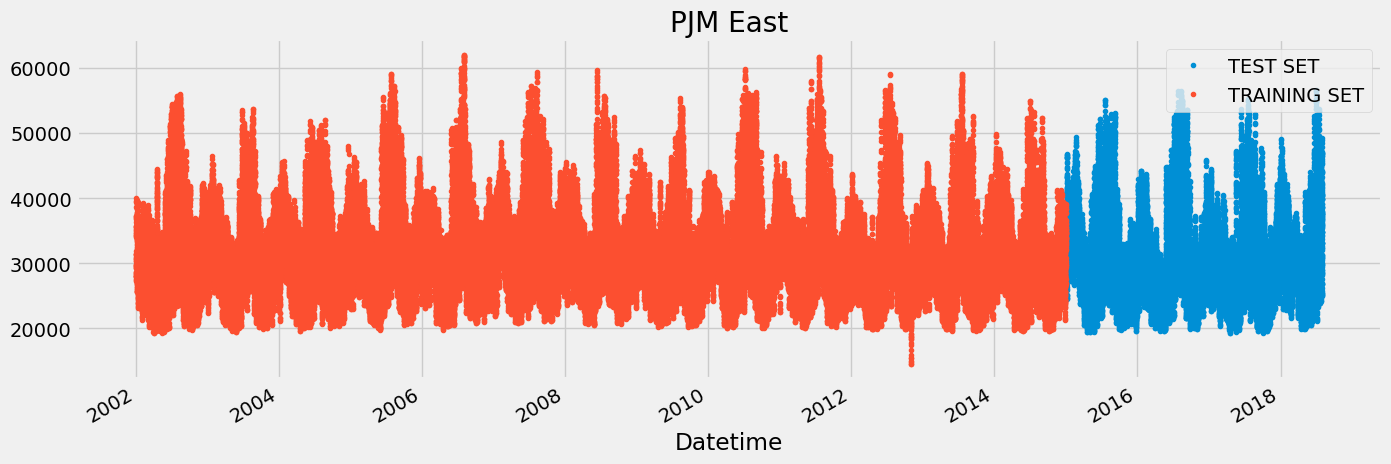

In [5]:
## Plot data points from training and test data sets
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### 5. Create Time Series Features

In [9]:
## Setting out main features by defining a function to do so
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    # df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
## Define key features for training and testing data sets 
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

### 6. Create XGBoost Model

In [11]:
## Initialize a XGBoost model with 1,000 estimators and then we train the model on training data set and deploy on the testing data set.
reg = xgb.XGBRegressor(n_estimators=1000)                                       # initializing a XGBoost model with the size of 1,000 decision trees
reg.fit(X_train, y_train,                                                       # fitting a model on training data set
        eval_set=[(X_train, y_train), (X_test, y_test)],                        # parameters to count the accuracy of the model is deployed
        early_stopping_rounds=50,                                               # number of rounds to stop training a model if the performance does not change
       verbose=False)                                                           # changing verbose to True to see how the model trains

C:\Users\Chuva\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 6.1. Feature Importances

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

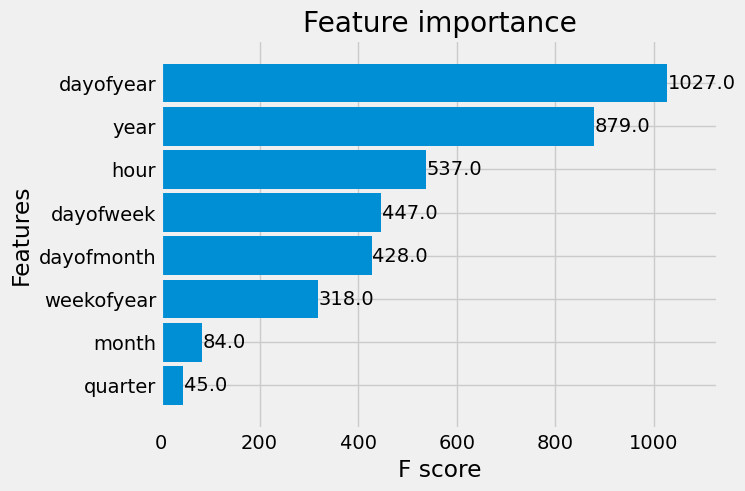

In [12]:
## Rank the features of a model (in descending order)
_ = plot_importance(reg, height=0.9)

Summary: We can see that the `day of year` was most commonly used to split trees, while `year` and `hour` came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

### 6.2. Forecast on Test Set

In [13]:
## Predicting a target value and join the training, and testing data sets together
pjme_test['MW_Prediction'] = reg.predict(X_test)                        ## predict a target value (hourly electricity consumption) using training model based on the features from a testing data set
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)               ## concate the training and testing data sets

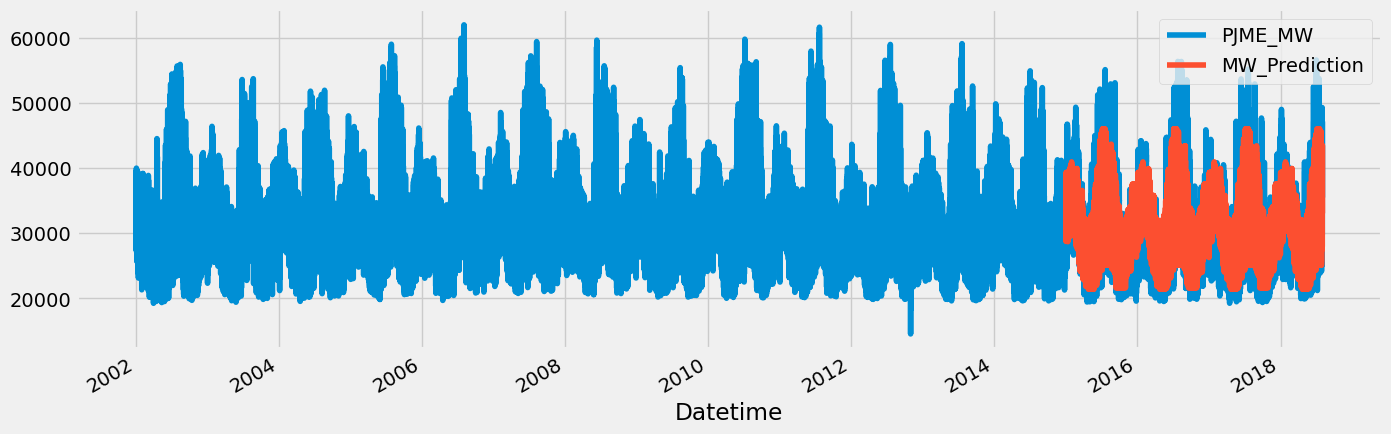

In [14]:
## Plot the prediction values (orange) to the original data set
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

### 6.3. Look at predictions versus actuals

#### Plot the actual and forecasted hourly electricity consumption in January 2015

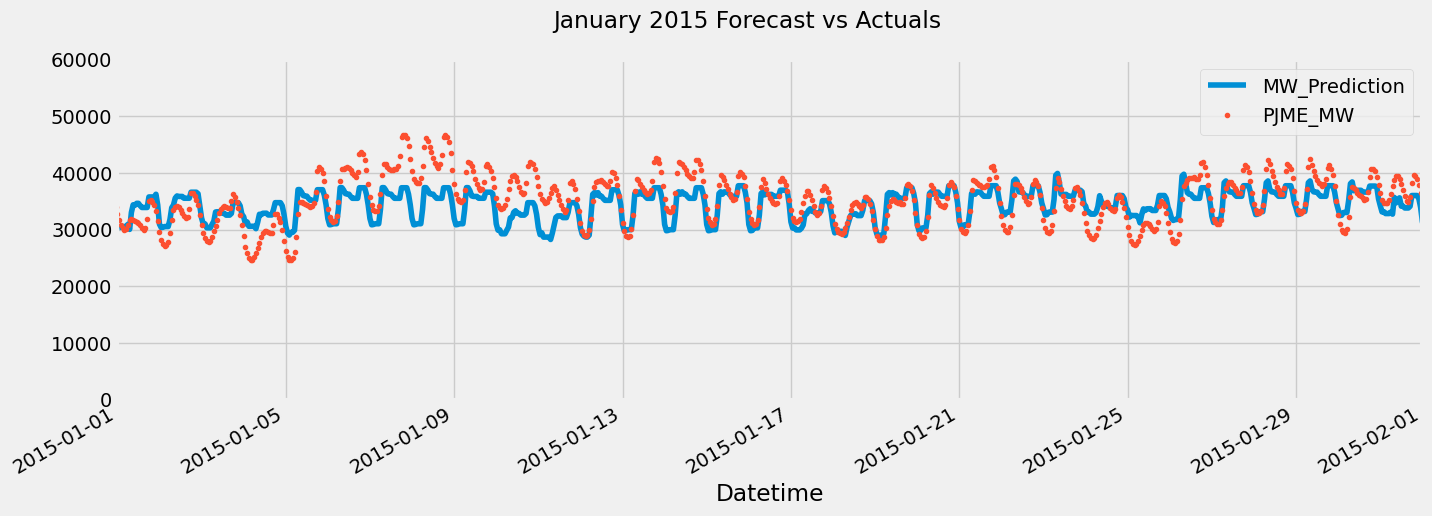

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

#### Plot the actual and forecasted hourly electricity consumption for the first week of January 2015

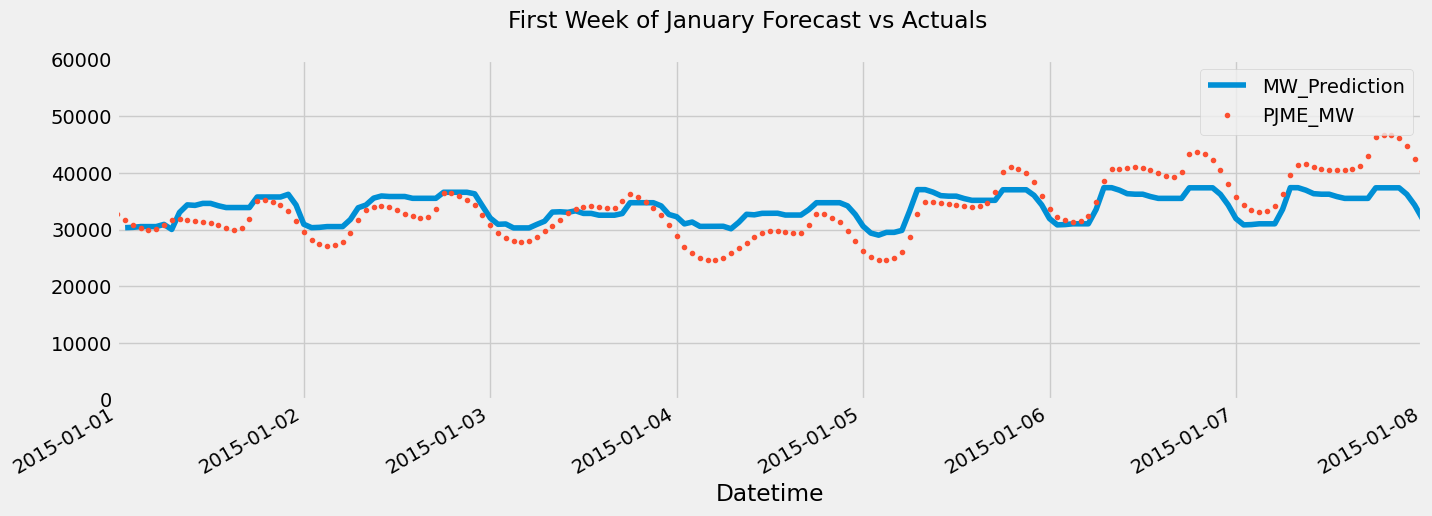

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

#### Plot the actual and forecasted hourly electricity consumption for the first week of July 2015

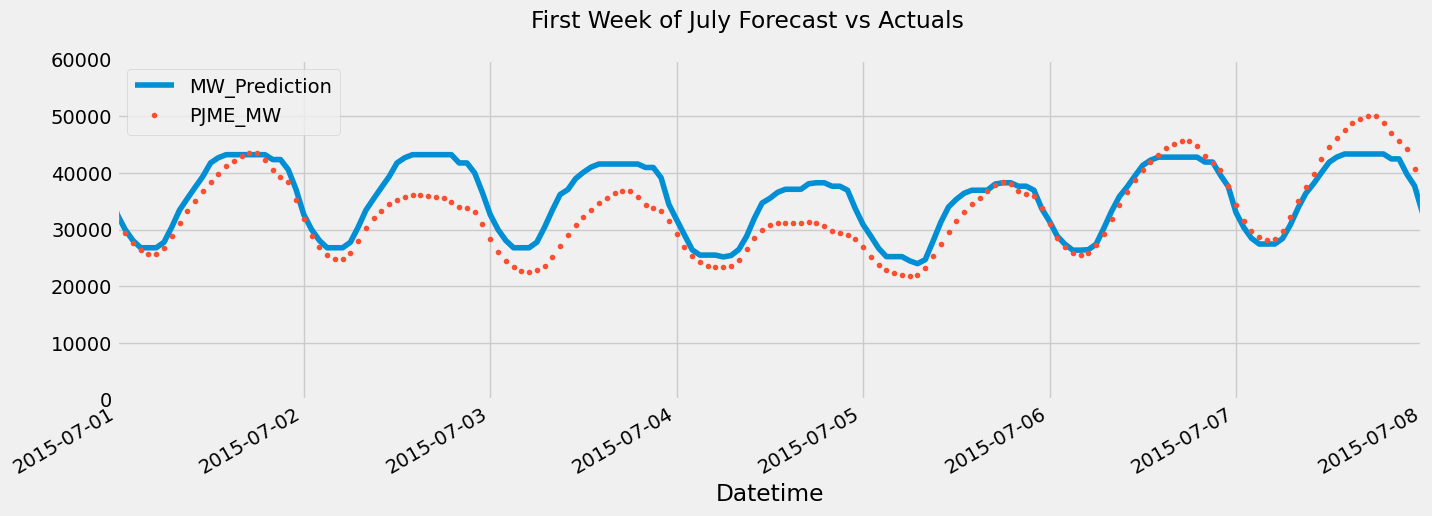

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### 6.4. Error Metrics On Test Set


To clearly define the error statistics between predicted and actual average hourly electricity consumption let use the following metrics like the mean squared error (MSE), the root mean square error (RMSE). The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. Finally, we will compute the mean absolute percentage error (MAPE).

* The mean squared error (MSE) measures the magnitude of the errors between the predicted and actual values of electricity consumption for a certain period of time.
* Subsequently, we will calculate the root mean square error (RMSE) which is simply the square root of the mean squared error (MSE), and use it to limit biased of the statistics variable for a large data set.
* Definitely, we will define the mean absolute percentage error (MAPE) because it gives us an easy to interperate percentage showing how off the predictions are. 

In [15]:
## Define the mean squared error (MSE)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14055329.714256588

In [16]:
## Calculate the root mean squared error (RMSE)
import math
print(math.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])))

3749.043840001953


In [17]:
# ## Define the mean_absolute_error (MSE)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2905.541158635075

In [21]:
## We need munualy create a function "mean_absolute_percentage_error" to calculate the mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
## Call a function "mean_absolute_percentage_error" to calculate the mean absolute percentage error
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.239324261253785

Summary: 
* MSE: The 13960913.30 is the average squared error between actual and predicted values of electricity consumption from 01 January, 2015 to 31 December, 2018
* RMSE: The value of 3736.43 denotes the avarage standard deviation from a mean electricity consumption in a tested data set from 01 January, 2015 to 31 December, 2018
* MAPE: The 8.51% is the value of error between predocted and actual values of electricity consumption in a teat set from 01 January, 2015 to 31 December, 2018


### 6.5. Look at the Worst and the Best Predicted Days

Try to figure out the most accurate predicted days (best) and the inaccurate predicted days (worse)

In [22]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [23]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37517.796875 -9117.839681  9117.839681
2017 2     24          26445.083333   34674.246094 -8229.161458  8229.161458
           25          24344.458333   32168.185547 -7823.726562  7823.726562
           20          27070.583333   34739.832031 -7669.247314  7669.247314
           23          27663.416667   35189.988281 -7526.572591  7526.572591
           19          24555.500000   32075.916016 -7520.415690  7520.415690
2018 2     21          27572.500000   35071.636719 -7499.138509  7499.138509
2017 2     28          28297.875000   35777.996094 -7480.123128  7480.123128
2015 12    25          24466.083333   31934.242188 -7468.158447  7468.158447
2017 5     29          24528.416667   31898.537109 -7370.119873  7370.119873

Summary: 
* #1 worst day - July 4th, 2016         - that is a national holiday in the US (Independence Day)
* #3 worst day - December 25th, 2015    - it is Christmas
* #5 worst day - September 4th, 2017    - it is a holiday in the US (Labor day) 

Looks like our model may benefit from adding a holiday indicator

#### Overview the worst predicted days

In [24]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31933.914062  13251.918294  13251.918294
           14          44427.333333   31571.750000  12855.583659  12855.583659
     9     10          40996.166667   29232.009766  11764.157145  11764.157145
           9           43836.958333   32909.222656  10927.734863  10927.734863
2018 1     6           43565.750000   33295.785156  10269.967285  10269.967285
2016 8     12          45724.708333   35532.207031  10192.502441  10192.502441
2015 2     20          44694.041667   34555.894531  10138.147624  10138.147624
2018 1     7           42159.708333   32626.416016   9533.292318   9533.292318
2017 5     19          38032.583333   28695.617188   9336.965169   9336.965169
2015 2     16          43949.500000   34774.941406   9174.557210   9174.557210

Summary: The worst predicted days seem to be a lot of October (not so many holidays on these dates)

In [25]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 12    30          32213.458333   32181.333984   32.125244  293.829183
     10    27          28611.166667   28468.591797  142.576579  395.899007
2017 10    24          28657.416667   28500.578125  156.839274  418.409749
2015 10    28          28500.958333   28500.578125    0.380941  437.252360
     5     6           28948.666667   28924.179688   24.486898  467.199788
2016 8     8           36256.041667   36075.062500  180.978190  565.314616
2017 9     14          32033.875000   31962.031250   71.842448  596.341634
     5     2           28546.916667   28924.179688 -377.263102  596.743408
     8     12          31822.666667   32056.876953 -234.211263  597.051595
2016 12    12          32757.208333   33159.648438 -402.439290  597.560872

Summary: The best predicted days seem to be in May and April (not many holidays and mild weather)

### 6.6. Plotting some best / worst predicted days

#### Plotting hourly predicted and actual values of electricity consumption from 13 August, 2016 to 14 August, 2016

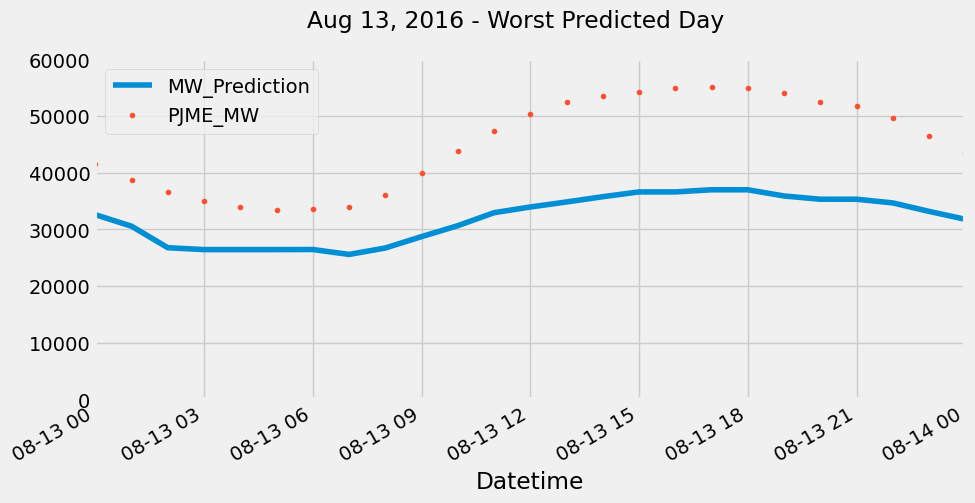

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

Summary: We can see the bad prediction level of electricity consumption from 13 August, 2016 to 14 August, 2016

#### Plotting hourly predicted and actual values of electricity consumption from 03 October, 2016 to 04 October, 2016

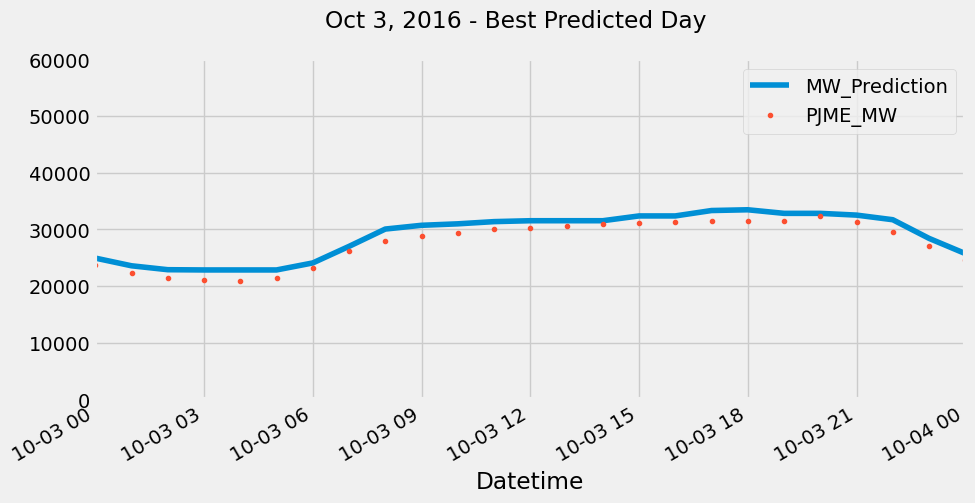

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

Summary: We can see the great prediction level of electricity consumption from 03 October, 2016 to 04 October, 2016

#### Plotting hourly predicted and actual values of electricity consumption from 13 August, 2016 to 14 August, 2016

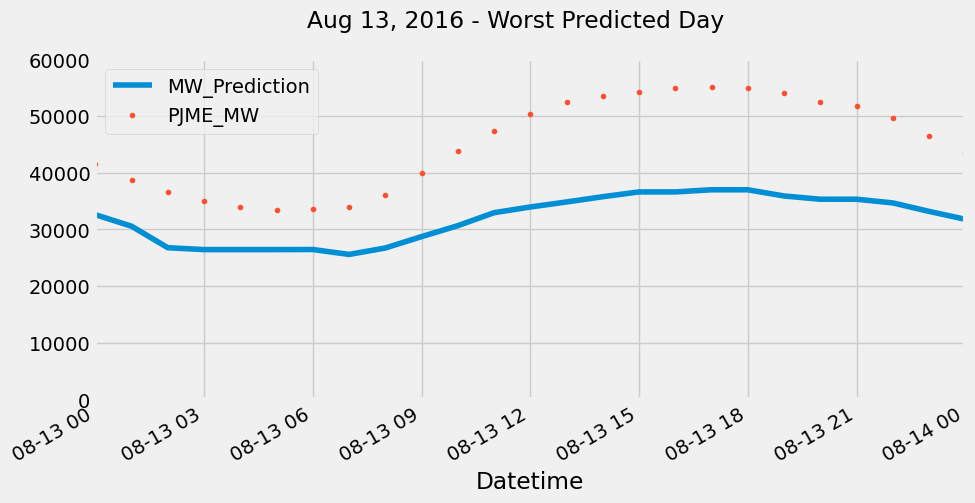

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

Summary: We can see the bad prediction level of electricity consumption from 13 August, 2016 to 14 August, 2016